# State of the Art Comparison on MNIST

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import seaborn as sns 

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss, brier_score_loss

from macest.classification import models as clmod
from macest.classification import metrics as clmet
from macest.classification import plots as clplot
from macest.model_selection import KFoldConfidenceSplit

In [16]:
sns.set_context("notebook")
sns.set_style('darkgrid')

In [4]:
# Uncomment this section if you have a `SSL: CERTIFICATE_VERIFY_FAILED` error
# See: https://github.com/scikit-learn/scikit-learn/issues/10201

# import os, ssl
# if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
#     getattr(ssl, '_create_unverified_context', None)): 
#     ssl._create_default_https_context = ssl._create_unverified_context

In [18]:
mnist = datasets.fetch_openml(name="mnist_784", parser="auto")
X = mnist.data.astype('float64')
y = mnist.target

In [19]:
X = X/256

In [20]:
enc = LabelEncoder()
y = enc.fit_transform(y)

### We do not want to work with the raw pixel values as features so we will take principal components

In [54]:
X_pp_train, X_conf_train, y_pp_train, y_conf_train  = train_test_split(X, y, test_size=0.6, random_state=1)

pca = PCA(n_components=50)
pca.fit(X_pp_train.values)

X_pp_train = pca.transform(X_pp_train.values)
X_conf_train = pca.transform(X_conf_train.values)

X_conf_train, X_cal, y_conf_train, y_cal = train_test_split(X_conf_train, y_conf_train,
                                                            test_size=0.4, random_state=0)
X_cal, X_test, y_cal,  y_test, = train_test_split(X_cal, y_cal, test_size=0.4, random_state=0)

In [55]:
model = RandomForestClassifier(random_state =0,
                               n_estimators =800,
                               n_jobs =-1)

model.fit(X_pp_train, y_pp_train)

RandomForestClassifier(n_estimators=800, n_jobs=-1, random_state=0)

In [56]:
print(model.score(X_pp_train, y_pp_train))
print(model.score(X_conf_train, y_conf_train))
print(model.score(X_cal, y_cal))
print(model.score(X_test, y_test))

1.0
0.9482142857142857
0.9451388888888889
0.9501488095238095


In [57]:
print(X_pp_train.shape)
print(X_conf_train.shape)
print(X_cal.shape)
print(X_test.shape)

(28000, 50)
(25200, 50)
(10080, 50)
(6720, 50)


### Set the MACEst Parameters

In [58]:
param_bounds = clmod.SearchBounds(k_bounds = (5,50))
neighbour_search_params = clmod.HnswGraphArgs(query_args = dict(ef = 1000))
optimiser_args = dict(popsize = 25, disp = False)

In [59]:
macest_model = clmod.ModelWithConfidence(model,
                                         X_conf_train,
                                         y_conf_train, 
                                         search_method_args=neighbour_search_params)

macest_model.fit(X_cal,
                 y_cal,
                 param_range = param_bounds,\
                 optimiser_args= optimiser_args)

In [60]:
preds = model.predict(X_cal)
conf_preds = macest_model.predict_proba(X_cal)
rf_conf = model.predict_proba(X_cal)
macest_point_prediction_conf = macest_model.predict_confidence_of_point_prediction(X_cal)

### We will also calibrate the predictions using some SOTA calibrators to compare with

In [61]:
isotonic = CalibratedClassifierCV(model,
                                  cv='prefit',
                                  method='isotonic')

isotonic.fit(X_conf_train, y_conf_train)
isot = isotonic.predict_proba(X_cal)
isot_point_prediction_conf = isot[np.arange(len(isot)), preds]

platt = CalibratedClassifierCV(model,
                                  cv='prefit',
                                  method= 'sigmoid')

platt.fit(X_conf_train, y_conf_train)
plat = platt.predict_proba(X_cal)
platt_point_prediction_conf = plat[np.arange(len(plat)), preds]

## Unseen Data

### Plot the reliability diagrams as well as barplots comparing calibration and forecast metrics

In [62]:
preds = model.predict(X_test)
conf_preds = macest_model.predict_proba(X_test)
rf_conf = model.predict_proba(X_test)
macest_point_prediction_conf = macest_model.predict_confidence_of_point_prediction(X_test)

In [63]:
isot = isotonic.predict_proba(X_test)
isot_point_prediction_conf = isot[np.arange(len(isot)), preds]

plat = platt.predict_proba(X_test)
platt_point_prediction_conf = plat[np.arange(len(plat)), preds]

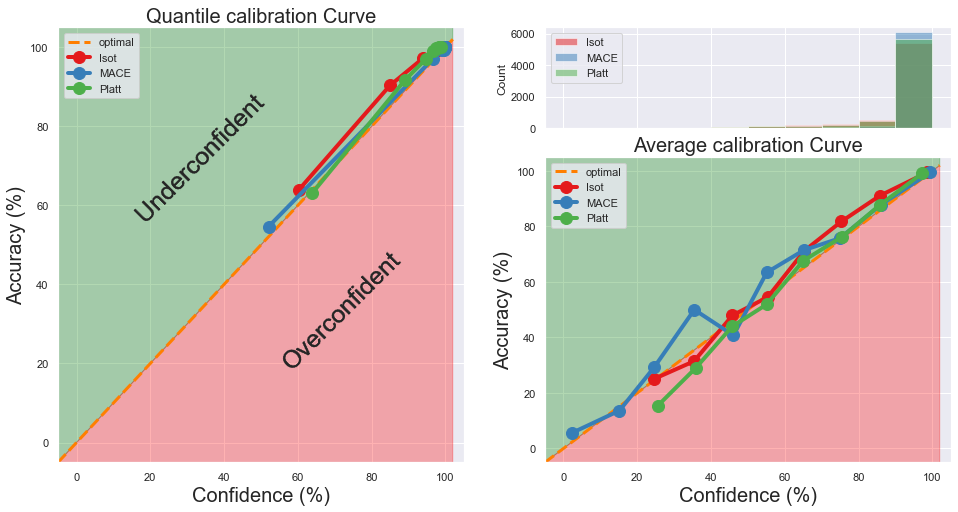

In [64]:
clplot.plot_calibration_curve([isot_point_prediction_conf,
                               macest_point_prediction_conf, 
                               platt_point_prediction_conf], 
                               ['Isot', 'MACEst', 'Platt'],
                               preds, y_test)

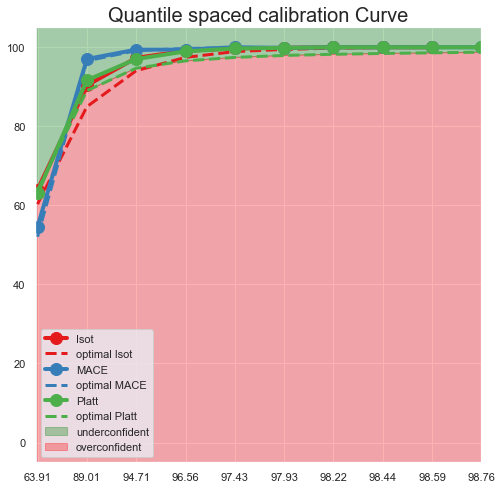

In [65]:
clplot.plot_quantile_spaced_calibration_curve([isot_point_prediction_conf,
                                               macest_point_prediction_conf, 
                                               platt_point_prediction_conf], 
                                              ['Isot', 'MACEst', 'Platt'],
                                              preds, y_test)

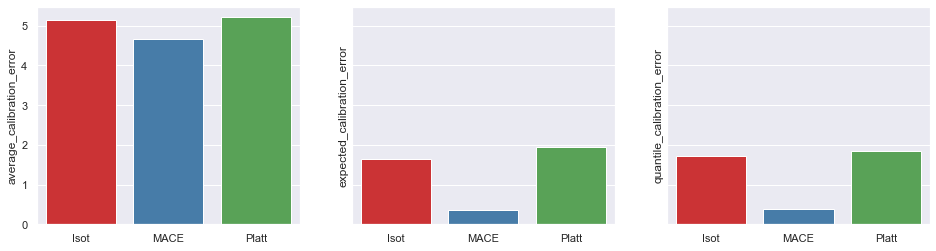

In [66]:
clplot.plot_calibration_metrics([isot_point_prediction_conf,
                                 macest_point_prediction_conf, 
                                 platt_point_prediction_conf], 
                                ['Isot', 'MACEst', 'Platt'],
                                preds, y_test)

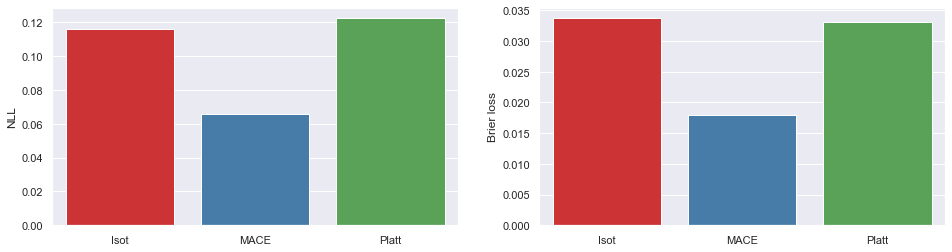

In [67]:
clplot.plot_forecast_metrics([isot_point_prediction_conf,
                              macest_point_prediction_conf, 
                              platt_point_prediction_conf], 
                             ['Isot', 'MACEst', 'Platt'],
                             preds, y_test)

### Here we will highlight a key difference between MACE and other Calibrators by attempting to classify noise

In [68]:
np.random.seed(10)
fake_points = np.random.uniform(0, 1, size=(10**4, 784))
test_point = fake_points[0].reshape(28,28)

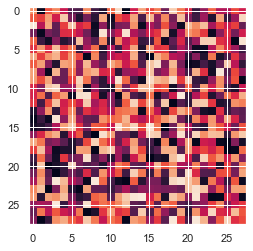

In [69]:
plt.imshow(test_point,
           interpolation='nearest')
plt.show()

In [70]:
fake_points = pca.transform(fake_points)

In [81]:
mace = macest_model.predict_confidence_of_point_prediction(fake_points[0:5])
iso = np.amax(isotonic.predict_proba(fake_points[0:5]), axis=1)
plat = np.amax(platt.predict_proba(fake_points[0:5]), axis=1)

In [82]:
model.predict(fake_points)[0]

2

#### The point prediction Model says that this point is a 2, MACE reports a low confidence for this whereas each of the others are > 75% confident
#### This is because MACE is an independent estimate rather than trying to scale the model confidence

In [83]:
mace[0]

0.040487591182840614

In [84]:
iso[0]

0.8419138908005586

In [85]:
plat[0]

0.8761125496226883

### Let's generate a bunch of noise points and compare the predicted confidence distributions
### We see here that MACEst is able to detect out of sample predictions and report low confidence for these

In [86]:
fake_points = np.random.uniform(0,1, size = (10**3, 784))
fake_points = pca.transform(fake_points)

mace = macest_model.predict_confidence_of_point_prediction(fake_points)
iso = np.amax(isotonic.predict_proba(fake_points), axis=1)
plat = np.amax(platt.predict_proba(fake_points), axis=1)

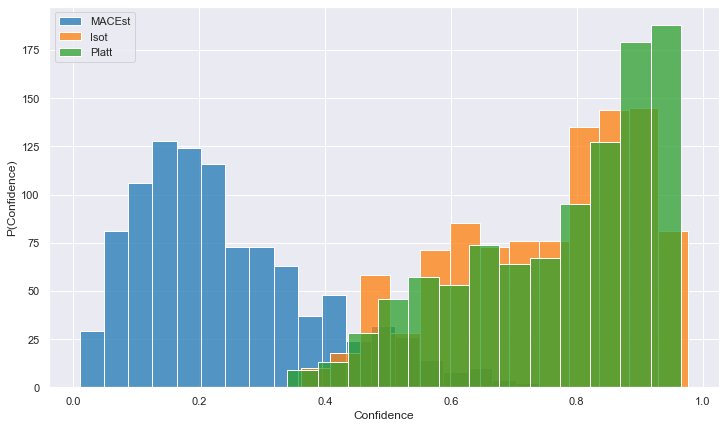

In [153]:
plt.figure(figsize = (12,7))
sns.histplot(mace, label="MACEst", color="C0")
sns.histplot(iso, label="Isot", color="C1")
sns.histplot(plat, label="Platt", color="C2")
plt.ylabel('P(Confidence)')
plt.xlabel('Confidence')
plt.legend()

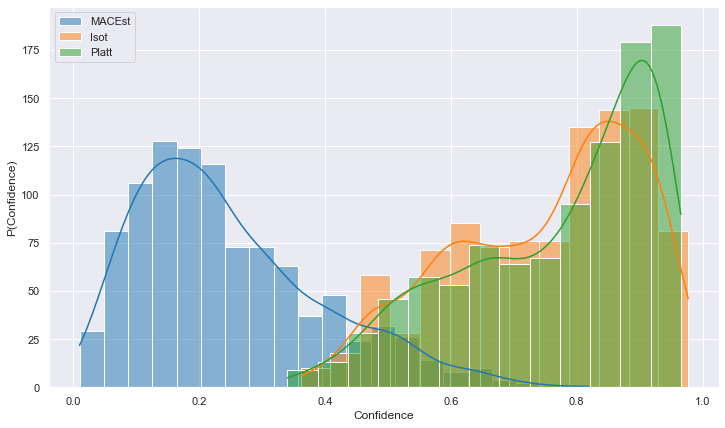

In [159]:
plt.figure(figsize = (12,7))
sns.histplot(mace,
             kde=True,
             kde_kws = dict(cumulative=True),
             label = 'MACEst', 
             color="C0")
sns.histplot(iso, 
             kde=True,
             kde_kws = dict(cumulative=True),
             label = 'Isot', 
             color="C1")

sns.histplot(plat, 
             kde=True,
             kde_kws = dict(cumulative=True),
             label = 'Platt', 
             color="C2")
plt.ylabel('P(Confidence)')
plt.xlabel('Confidence')
plt.legend()

### Let's compare MACEst with the other SOTA calibrators using k fold classification

In [160]:
X = mnist.data.astype('float64')
y = mnist.target

In [161]:
X = X/256

In [162]:
enc = LabelEncoder()
y = enc.fit_transform(y)

In [163]:
hsnw_params = clmod.HnswGraphArgs(init_args= dict(method = 'hnsw',
                                                  space = 'l2'))

optimiser_args = dict(popsize = 30, disp =False)

param_range = clmod.SearchBounds(k_bounds = (5,30))

In [164]:
model = RandomForestClassifier(random_state=0,
                               n_estimators=200,
                               n_jobs=-1)
    
model.fit(X_pp_train, y_pp_train)

RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=0)

In [165]:
model.score(X_test, y_test)

0.9486607142857143

### Compute calibration errors for existing state of the art calibration methods

Prime error recording lists

In [166]:
accuracy = []

macest_ece, macest_pwece, macest_nll, macest_brier = [], [], [], []
macest_cal_ece, is_cal_ece, platt_cal_ece, temp_cal_ece, diri_cal_ece = [], [], [], [], []
is_ece, is_pwece, is_nll, is_brier = [], [], [], []
platt_ece, platt_pwece, platt_nll, platt_brier = [], [], [], []
temp_ece, temp_pwece, temp_nll, temp_brier = [], [], [], []

diri_ece, diri_pwece, diri_nll, diri_brier = [], [], [], []

kfold = KFoldConfidenceSplit(n_splits=5,
                             pp_train_graph_cal_split = (0.5, 0.15, 0.35))

optimiser_args = dict(popsize=20, disp=False)

Compute calibration errors over the folds

In [173]:
i = 0

for train_idxs, conf_cal_idxs, conf_graph_idxs, test_idxs in kfold.split(X):
    print(" ")
    print(f'starting fold {i}' )
    
    X_pp_train = X.values[train_idxs]
    y_pp_train =  y[train_idxs]
    
    X_test = X.values[test_idxs]
    y_test = y[test_idxs]
    
    X_cal = X.values[conf_cal_idxs]
    y_cal = y[conf_cal_idxs]
    
    X_conf_train = X.values[conf_graph_idxs]
    y_conf_train = y[conf_graph_idxs]
    
    pca = PCA(n_components=50)
    pca.fit(X_pp_train)
    
    pca.fit(X_pp_train, y_pp_train)

    X_pp_train = pca.transform(X_pp_train)
    X_conf_train = pca.transform(X_conf_train)
    X_cal = pca.transform(X_cal)
    X_test = pca.transform(X_test)

    model = RandomForestClassifier(random_state=0,
                                   n_estimators=200,
                                   n_jobs=-1)
    
    model.fit(X_pp_train, y_pp_train)
    
    accuracy.append(model.score(X_test, y_test))

    mace = clmod.ModelWithConfidence(model,
                                     X_conf_train,
                                     y_conf_train, 
                                     search_method_args=hsnw_params)

    mace.fit(X_cal, y_cal, optimiser_args = optimiser_args)
    
    isotonic = CalibratedClassifierCV(model,
                                      cv='prefit',
                                      method='isotonic')
    isotonic.fit(X_conf_train, y_conf_train)
    
    platt = CalibratedClassifierCV(model,
                                   cv='prefit',
                                   method='sigmoid')
    
    platt.fit(X_conf_train, y_conf_train)    

    preds = model.predict(X_test)
    correct = preds == y_test

    macest_conf_preds = mace.predict_confidence_of_point_prediction(X_test)
    is_conf_preds = np.amax(isotonic.predict_proba(X_test), axis=1)
    platt_conf_preds = np.amax(platt.predict_proba(X_test), axis=1)
    
    macest_ece.append(clmet.expected_calibration_error(preds, y_test, macest_conf_preds))
    print(macest_ece[i])
    macest_pwece.append(clmet.class_wise_expected_calibration_error(preds, y_test, macest_conf_preds))
    macest_nll.append(log_loss(correct, macest_conf_preds))
    macest_brier.append(brier_score_loss(correct, macest_conf_preds))
    
    macest_cal_ece.append(np.mean(clmet.simulate_from_calibrated_model(macest_conf_preds,
                                                       samples =10**3)))
    
    is_cal_ece.append(np.mean(clmet.simulate_from_calibrated_model(is_conf_preds,
                                                       samples =10**3)))
    
    platt_cal_ece.append(np.mean(clmet.simulate_from_calibrated_model(platt_conf_preds,
                                                       samples =10**3)))

    is_ece.append(clmet.expected_calibration_error(preds, y_test, is_conf_preds))
    is_pwece.append(clmet.class_wise_expected_calibration_error(preds, y_test, is_conf_preds))
    is_nll.append(log_loss(correct, is_conf_preds))
    is_brier.append(brier_score_loss(correct, is_conf_preds))
    
    platt_ece.append(clmet.expected_calibration_error(preds, y_test, platt_conf_preds))
    platt_pwece.append(clmet.class_wise_expected_calibration_error(preds, y_test, platt_conf_preds))
    platt_nll.append(log_loss(correct, platt_conf_preds))
    platt_brier.append(brier_score_loss(correct, platt_conf_preds))
    
    i += 1 

 
starting fold 0
0.444093929392098
 
starting fold 1
0.40245991243459617
 
starting fold 2
0.6046446662307193
 
starting fold 3
0.5215304534323393
 
starting fold 4
0.3557461285935905


### We now compare MACEst with the other classifiers on a variety of metrics

In [174]:
labels = ['MACEst', 'Isotonic', 'Platt']

Text(0, 0.5, 'ECE')

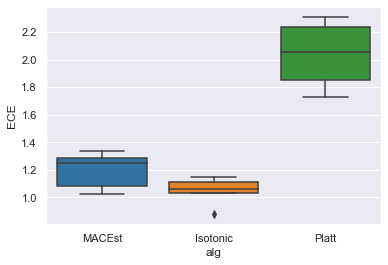

In [175]:
ece_df = pd.DataFrame([macest_pwece, is_pwece, platt_pwece], 
                      index=labels).unstack().reset_index()
ece_df.columns = ['iteration', 'alg', 'error']
sns.boxplot(x="alg", y="error", data=ece_df)
plt.ylabel('ECE')

Text(0, 0.5, 'CwECE')

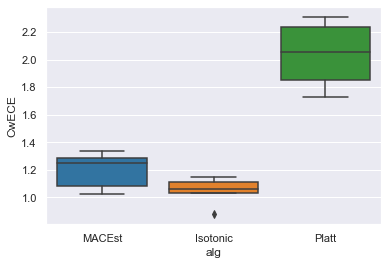

In [176]:
cwece_df = pd.DataFrame([macest_pwece, is_pwece, platt_pwece], 
                        index=labels).unstack().reset_index()
cwece_df.columns = ['iteration', 'alg', 'error']
sns.boxplot(x="alg", y="error", data=cwece_df)
plt.ylabel('CwECE')

Text(0, 0.5, 'NLL')

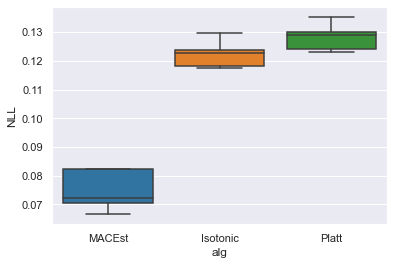

In [177]:
nll_df = pd.DataFrame([macest_nll, is_nll, platt_nll], 
                      index=labels).unstack().reset_index()
nll_df.columns = ['iteration', 'alg', 'error']
sns.boxplot(x="alg", y="error", data=nll_df)
plt.ylabel('NLL')

Text(0, 0.5, 'Brier')

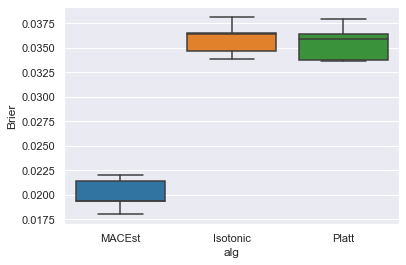

In [178]:
brier_df = pd.DataFrame([macest_brier, is_brier, platt_brier], 
                        index=labels).unstack().reset_index()
brier_df.columns = ['iteration', 'alg', 'error']
sns.boxplot(x="alg", y="error", data=brier_df)
plt.ylabel('Brier')